# Exploratory Data Analysis

In our first notebook, we will do an exploratory data analysis to understand data generation process, connection to the business case we want to solve and data inconsistencies and peculiarities.

Following CRISP-DM diagram illustrated below, we are working on Business Understanding, Data Understanding and Data Preparation steps.


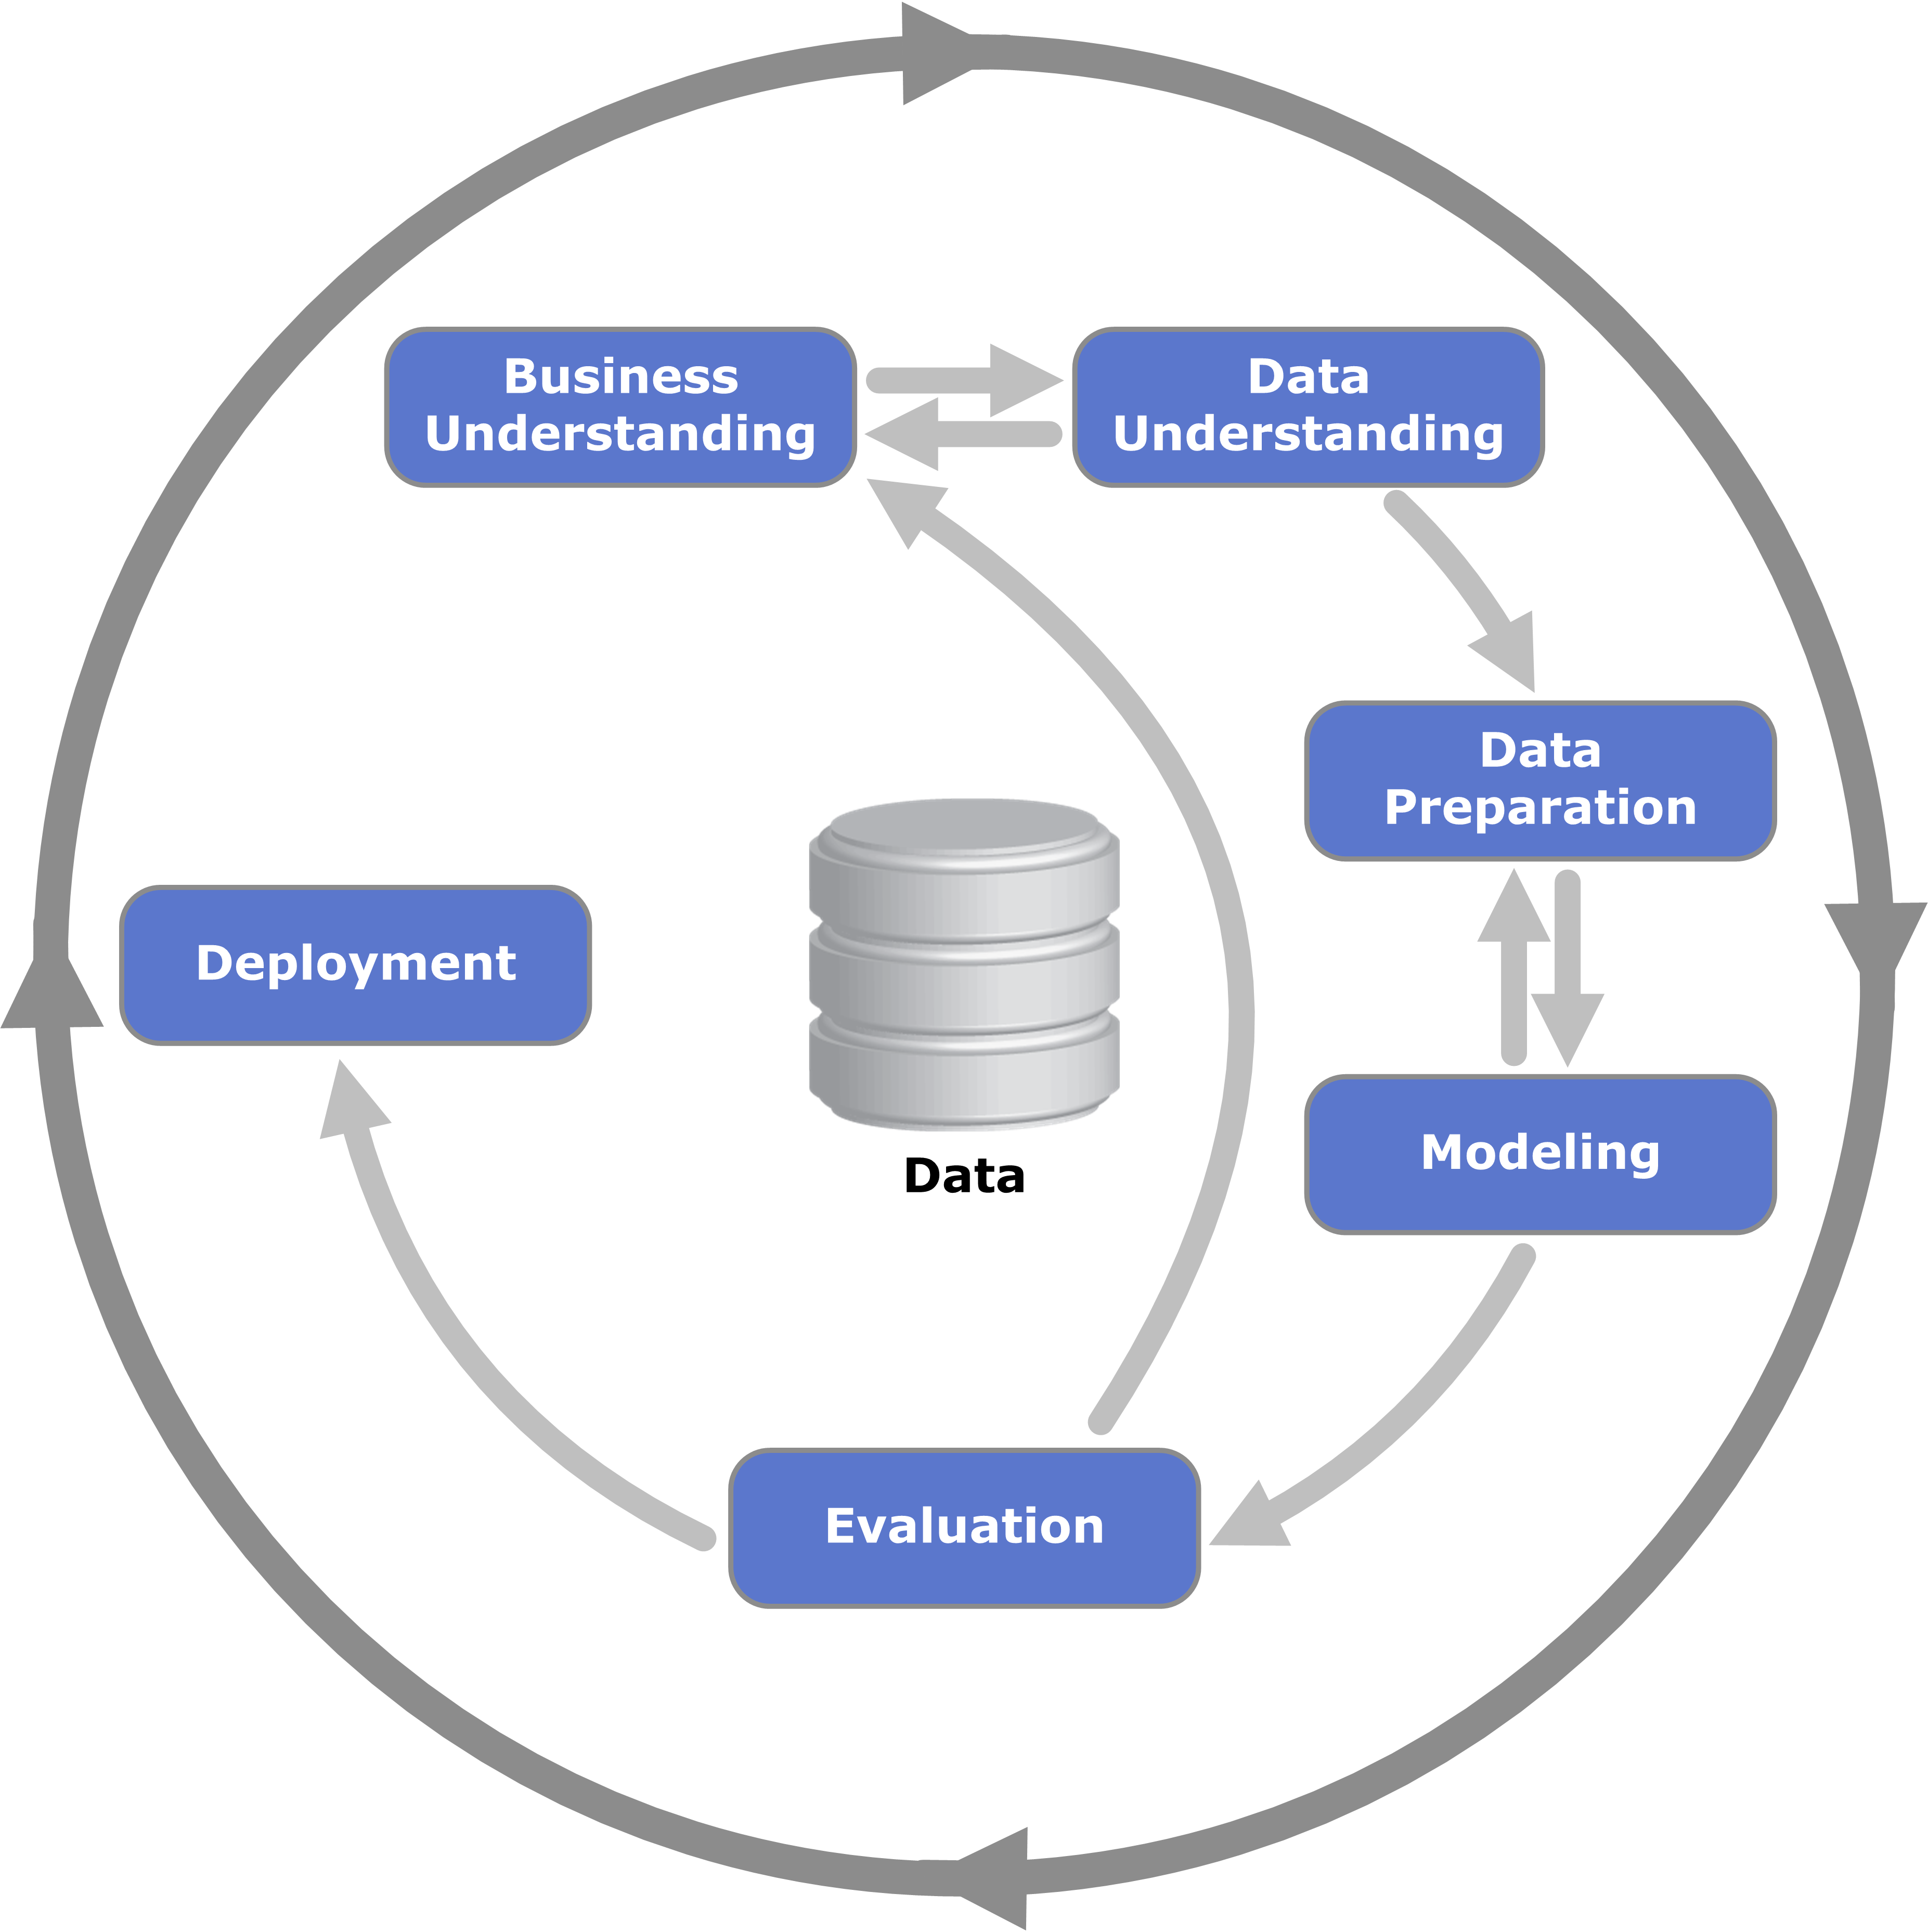

## Brief introduction to the Business

Doing a small research online, this data comes from Lending Club Data, a data source provided by Lending Club company, the largest peer-to-peer lending platform in the world. Basically, a lending platform connects borrowers and investors willing to take credit / make an investment. Investors choose loans based on the information supplied such as amount of loan, loan grade and loan purpose. 

In this business case, dataset contains current and past loans granted by the company. The goal of this project is to build a model to predict probability of default at the moment of loan application, where **default** client is defined as one with *loan_status* variables taking on the following levels:
 - charged off
 - default
 - doest not meet the credit policy. Status: Charged Off
 - late (31-120 days)
 
Thus, we need a deep understanding of our data to make a reliable model. During case's development, I will discuss all problems that can occur when working within this segment. However, let's first see how our data is organized and distributed, which features seems to have a strong signal and which do not.

### Importing data and libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf

# widgets to interact with plotly
cf.go_offline()

import pandas_profiling as pf
import missingno as msno

pd.set_option("max_columns", 50)

In [3]:
df = pd.read_csv("../data/raw/loan.csv")
df.shape

(2260668, 14)

In [4]:
df.head(5)

term  int_rate  installment grade sub_grade home_ownership  \
0   36 months     13.56        84.92     C        C1           RENT   
1   60 months     18.94       777.23     D        D2       MORTGAGE   
2   36 months     17.97       180.69     D        D1       MORTGAGE   
3   36 months     18.94       146.51     D        D2       MORTGAGE   
4   60 months     16.14       731.78     C        C4       MORTGAGE   

   annual_inc   issue_d loan_status    dti earliest_cr_line  recoveries  \
0     55000.0  Dec-2018     Current  18.24         Apr-2001         0.0   
1     90000.0  Dec-2018     Current  26.52         Jun-1987         0.0   
2     59280.0  Dec-2018     Current  10.51         Apr-2011         0.0   
3     92000.0  Dec-2018     Current  16.74         Feb-2006         0.0   
4     57250.0  Dec-2018     Current  26.35         Dec-2000         0.0   

  last_pymnt_d application_type  
0     Feb-2019       Individual  
1     Feb-2019       Individual  
2     Feb-2019       Individual  
3     Feb-2019       Individual  
4     Feb-2019       Individual

EDA is long work that usually take many hours of our work, therefore I like to start my analysis using pandas profiling library that gives you a great overview of our data. 

## ProfileReport

In [9]:
profile = pf.ProfileReport(df, minimal=True)
profile.to_file('../reports/loan_profile_report.html')

You can open the html report under reports folder.

To begin, we can list a few things:
 - *term* has only two distinct values, 36 months and 60 months, this is expected from data dictionary. However, we can see pandas is interpreting four values. Probably we have a few rows with trailing spaces.
 - *int_rate* is the interest rate of the loan, presumably quoted as the annual percentage rate. We need to confirm this looking at data. In summary, data is well-behaved and does not seem to have inconsistencies, although an interest of 30% is high. Data is approximately a normal distribution, with a minimum right-tail.
 - *installment* has a higher skewness than *int_rate*, but nothing too off. Values also seem normal.
 - *grade* and *sub_grade* both variables are classes assigned by LendingClub to borrowers. A small research on internet brought following result for the meaning of grades:
 
   - 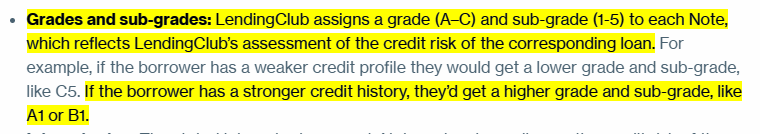
   I will use this evaluation, however it does not hurt to confirm in data.
   
 - *home_ownership* is another categorical variable that has a straight forward meaning. We should only look for the ones with None to see if this is a null values or if it means something.
 - *annual_inc* is a self-reported annual income provided by the borrower during registration. The self-reported part shows that weird things can happen. Zeros, outliers (or inconsistencies), and high skewness is presented in this variable. We need to process it further to check all these problems.
 - *issue_d* and *last_pymnt_d* are dates which loan was funded and last payment was received, respectively.  For *last_pymnt_d* we have 2426 null values. This can make sense depending on *loan_status* variable we will discuss below. Again, on exploration we will discuss it further.
 - *loan_status* is the target variable as indicated in introduction section. We have nine different loan status, as stated in the pdf case, four of them are classified as default and the one Fully Paid is clearly our negative class. We need to investigate further other status to see if they will become a part of our job or not.
 - *dit* or [debt to income rate](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income) is an important variable to summarize financial health condition for borrowers. Since it is a rate, we can see from profiling a few inconsistencies such as a value of 999, or -1, including missing values. We need to treat all of that **before** doign any analysis.
 - *earliest_cr_line* and *application_type* are ok. 
 - *recoveries* has a huge skew, because of zeros. We just need to check for outliers.

## Treating Data Inconsistencies and Null Values

Like discussed above, prior to doing our exploratory analysis, we need to have data in the right format. Obviously, this top-down approach does not always work, because in visualizing data and their relationships new things can come up, and we will deal with. 

In [5]:
def remove_trainling_spaces(df, column):
    df[column] = df[column].str.strip()
    
    return df

df_loan = remove_trainling_spaces(df, "term")
df_loan["term"].value_counts()

36 months    1609754
60 months     650914
Name: term, dtype: int64

missigno is a great library to visualize null values. Let's start plotting a matrix where null rows are white.

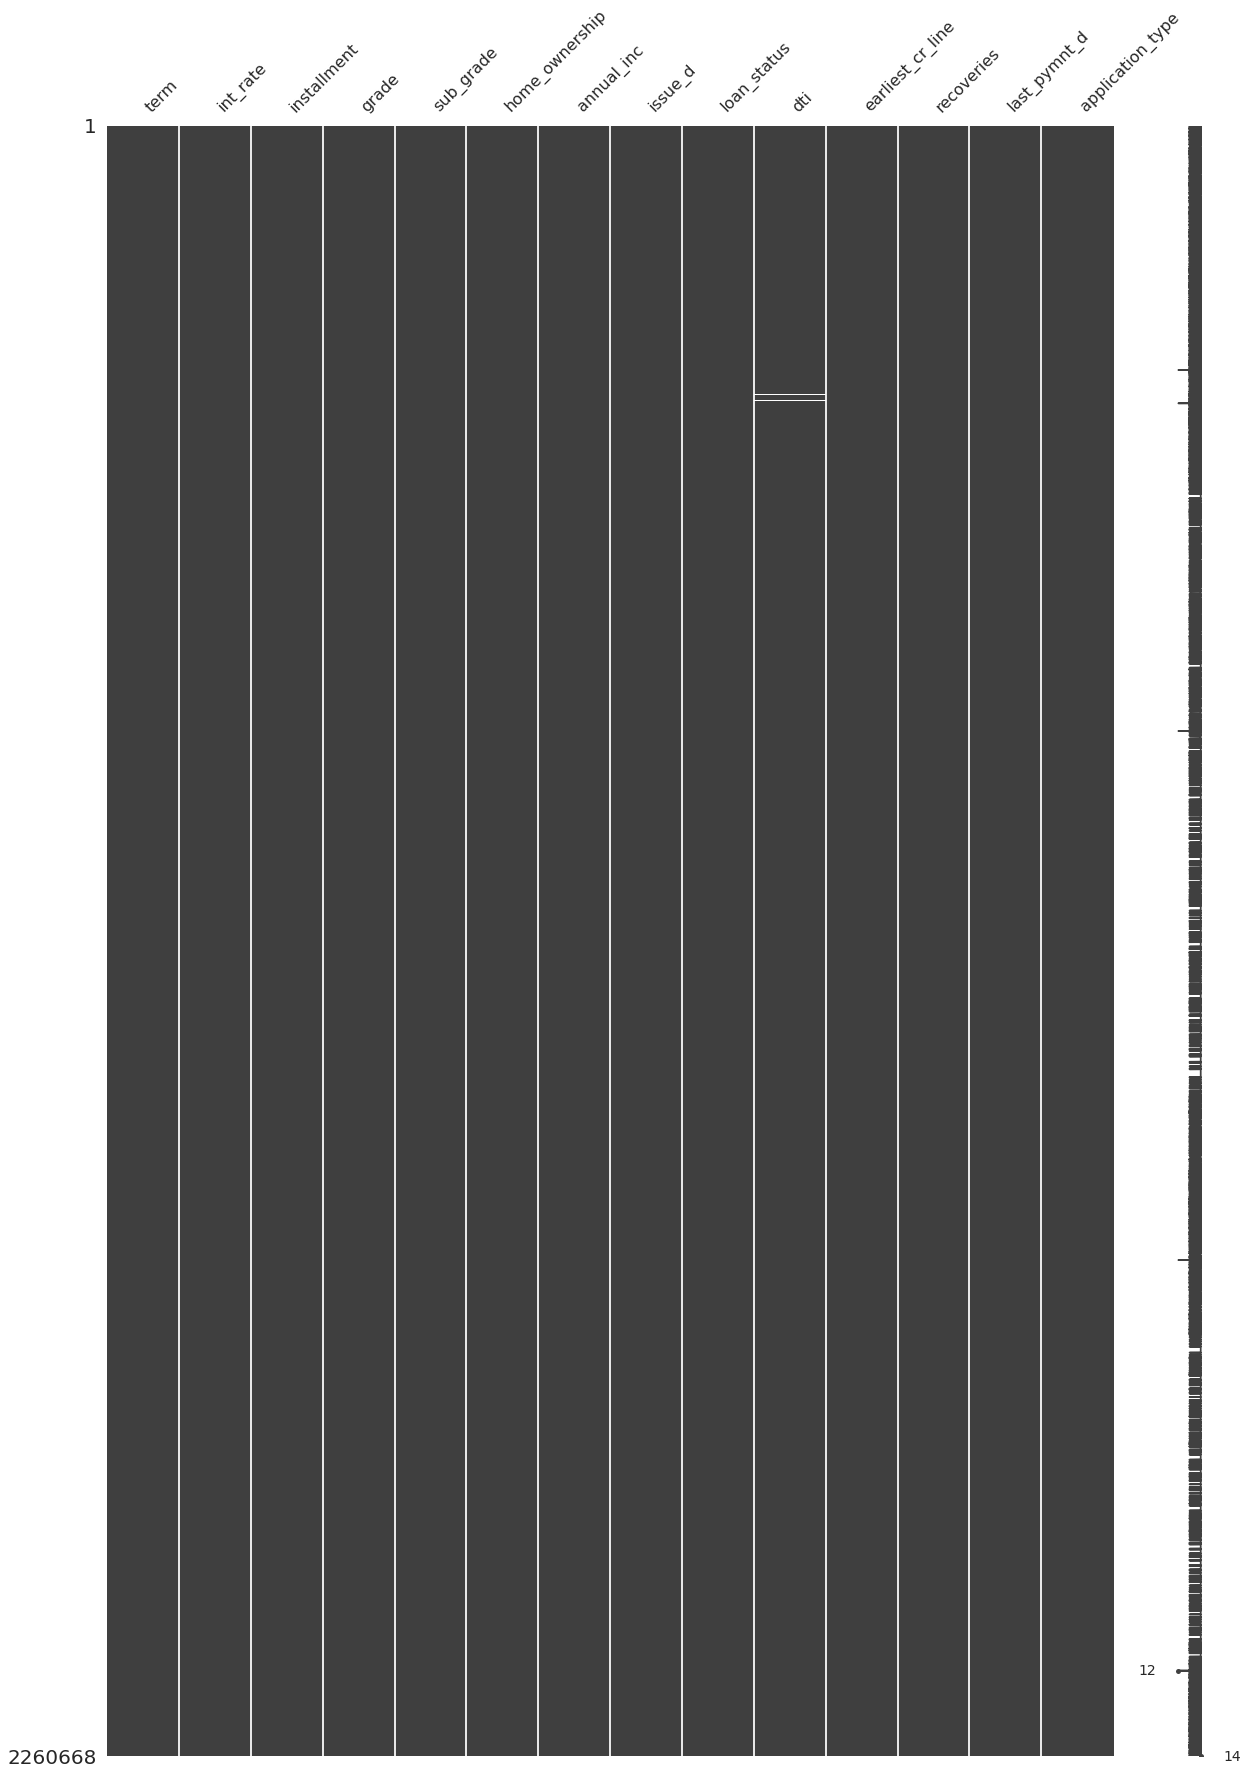

In [17]:
msno.matrix(df_loan, figsize=(20, 30))

There is no apparent relationship or pattern, we can also do a correlation plot.

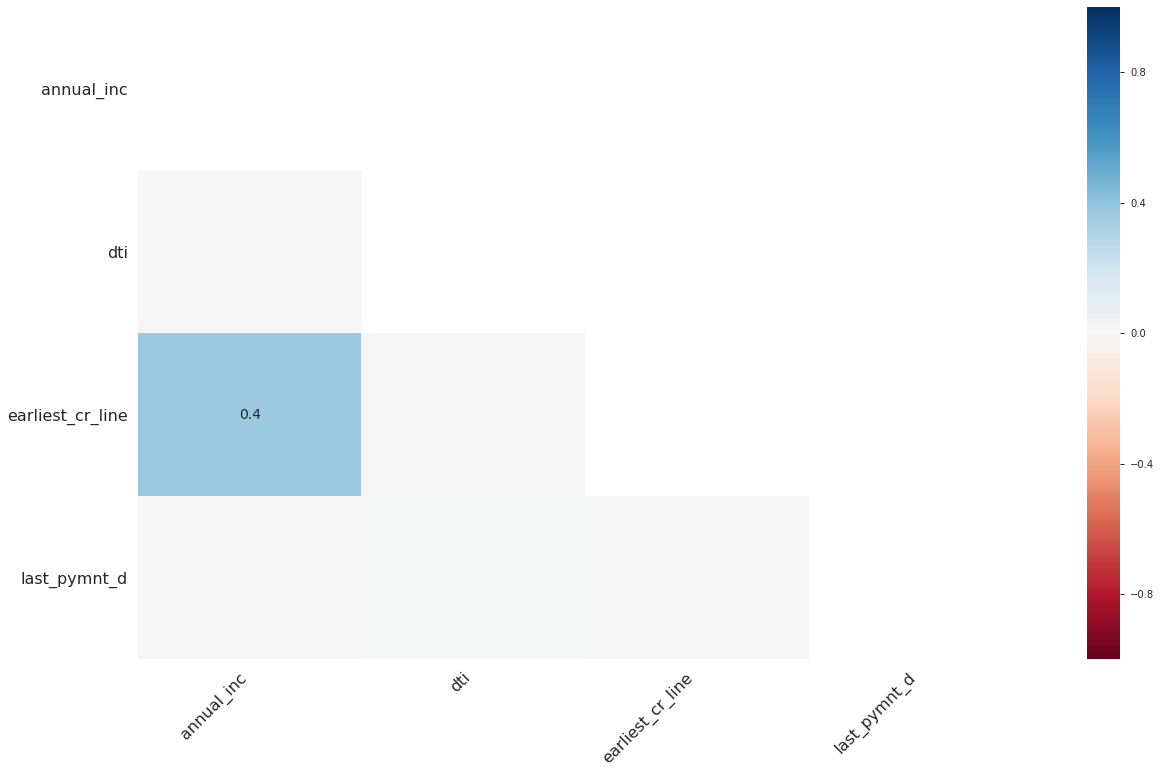

In [18]:
msno.heatmap(df_loan)

There seems to be a positive correlation between annual_income null values and earlist_cr_line. Let's do a bar plot counting null values again per variable.

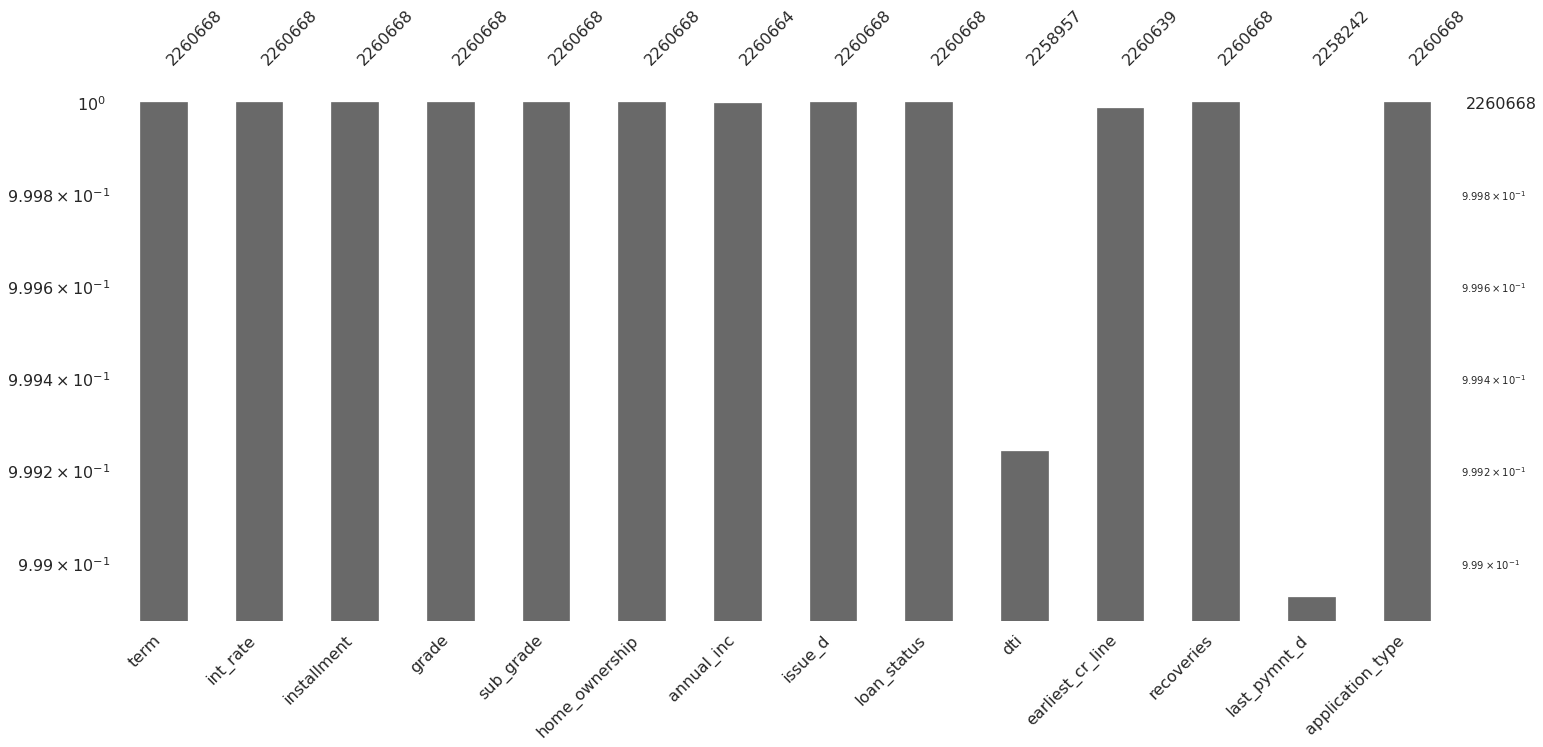

In [21]:
msno.bar(df_loan, log=True)

From above we can see *last_pymnt_d* and *dti* are the ones with most null values.

In [6]:
df_loan[df_loan["last_pymnt_d"].isnull()]["loan_status"].value_counts()

Charged Off                                            2260
Late (31-120 days)                                      153
Does not meet the credit policy. Status:Charged Off      12
Default                                                   1
Name: loan_status, dtype: int64

We can see that all null values for last payment date come from loan_status where borrowers has not paid for a long time. However, there are applications with last_payment_date not null that are charged off, presumably this can happen because the ones above did not make **any** payment. For now, I will keep these values as nulls.

In [7]:
df_loan[df_loan["dti"].isnull()]["annual_inc"].value_counts()

0.00     1659
1.00       42
10.00       5
0.36        1
2.00        1
6.00        1
3.00        1
8.00        1
Name: annual_inc, dtype: int64

It is not a surprise null values for dti since annual income seems to be wrong in those applications. Therefore, nothing we can do for now, maybe on data exploration we can have new insights in how to fill these null values. Let's check then data inconsistencies, to begin with *annual_inc* variable and their huge income reported values.

In [8]:
df_loan.loc[df_loan["annual_inc"].nlargest(10).index, :]

term  int_rate  installment grade sub_grade home_ownership  \
1519700  60 months      9.93       636.38     B        B2           RENT   
1369278  36 months     11.44       329.48     B        B4       MORTGAGE   
1458483  36 months     18.06       180.92     D        D2           RENT   
372715   36 months     14.07       547.39     C        C3       MORTGAGE   
61127    60 months     16.14       341.50     C        C4       MORTGAGE   
675605   36 months      7.39       931.68     A        A4            OWN   
714651   60 months      7.89       606.72     A        A5       MORTGAGE   
1381011  36 months     12.74      1174.91     C        C1       MORTGAGE   
1160644  60 months      7.89       485.38     A        A5       MORTGAGE   
1351377  60 months     10.49       515.74     B        B2       MORTGAGE   

          annual_inc   issue_d         loan_status   dti earliest_cr_line  \
1519700  110000000.0  Aug-2017             Current  0.01         Apr-1994   
1369278   61000000.0  Mar-2017             Current  0.01         Apr-1996   
1458483   10999200.0  Sep-2017          Fully Paid  0.07         Jan-1998   
372715     9930475.0  Apr-2018             Current  0.19         Feb-2008   
61127      9757200.0  Nov-2018             Current  0.15         Sep-2004   
675605     9573072.0  Apr-2016  Late (31-120 days)  0.16         May-2003   
714651     9550000.0  Mar-2016          Fully Paid  0.07         Feb-2006   
1381011    9522972.0  Mar-2017          Fully Paid  0.32         Aug-2006   
1160644    9500000.0  Jul-2015         Charged Off  0.12         Jul-1982   
1351377    9300086.0  Mar-2017             Current  0.33         Oct-1978   

         recoveries last_pymnt_d application_type  
1519700        0.00     Feb-2019       Individual  
1369278        0.00     Feb-2019       Individual  
1458483        0.00     Dec-2018       Individual  
372715         0.00     Feb-2019       Individual  
61127          0.00     Feb-2019       Individual  
675605         0.00     Nov-2018       Individual  
714651         0.00     Oct-2017       Individual  
1381011        0.00     Mar-2018       Individual  
1160644      452.95     Dec-2018       Individual  
1351377        0.00     Feb-2019       Individual

The top 1 shows a value of annual income of 110_000_000, this is huge, moreover grades are not consistent with that income, probably a mistake or misleading information. It is a good practice when dealing with these kind of self-reported variable to set a limit based on percentiles, quantiles or a business rule, I will apply same logic when building models because it is necessary to be prepared when productionizing your models.

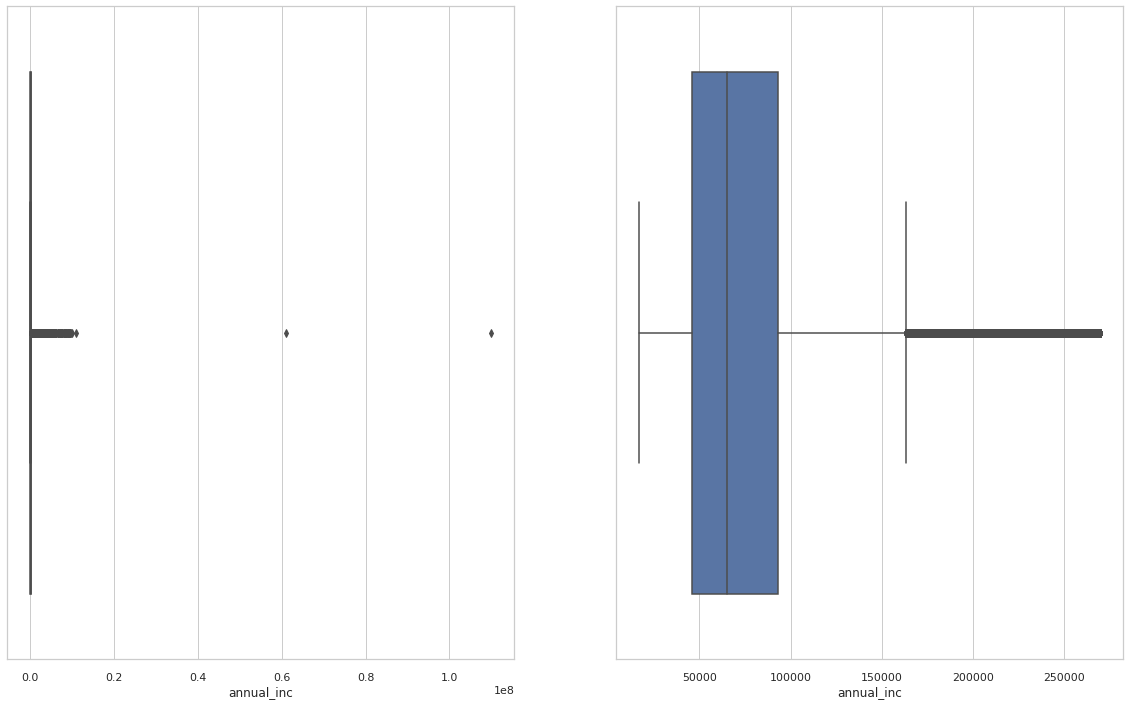

In [9]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

lower_inc, upper_inc = np.percentile(df_loan["annual_inc"].dropna().values, [1, 99]) 

sns.boxplot(df_loan["annual_inc"], ax=ax[0])
sns.boxplot(df_loan["annual_inc"].clip(lower=lower_inc, upper=upper_inc), ax=ax[1])

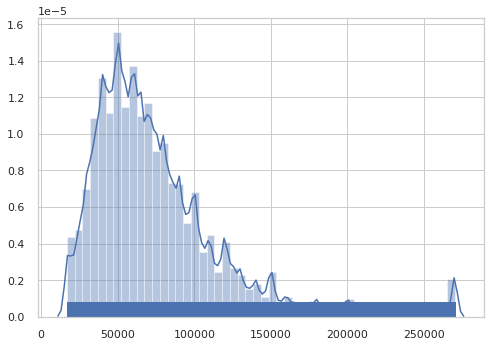

In [10]:
sns.distplot(df_loan["annual_inc"].clip(lower=lower_inc, upper=upper_inc).dropna().values, rug=True, kde=True)

We can see much nicer distribution plots. Although this is a quick and simple solution, it is useful to build a reliable model. Of course, we can change percentiles choosed varying from [1, 99] to [5, 95], but I will avoid extend this kind of discussions because of time limit. Here, we are just demonstrating ideas.

In [11]:
df_loan[df_loan["annual_inc"].isnull()]

term  int_rate  installment grade sub_grade home_ownership  \
2141934  36 months      7.43       155.38     A        A2           NONE   
2141935  36 months      7.75       218.55     A        A3           NONE   
2141965  36 months      7.75       209.18     A        A3           NONE   
2142018  36 months      8.38       204.84     A        A5           NONE   

         annual_inc   issue_d  \
2141934         NaN  Aug-2007   
2141935         NaN  Aug-2007   
2141965         NaN  Jul-2007   
2142018         NaN  Jun-2007   

                                               loan_status  dti  \
2141934  Does not meet the credit policy. Status:Fully ...  1.0   
2141935  Does not meet the credit policy. Status:Fully ...  1.0   
2141965  Does not meet the credit policy. Status:Fully ...  1.0   
2142018  Does not meet the credit policy. Status:Fully ...  4.0   

        earliest_cr_line  recoveries last_pymnt_d application_type  
2141934              NaN         0.0     Aug-2010       Individual  
2141935              NaN         0.0     Aug-2010       Individual  
2141965              NaN         0.0     Jul-2010       Individual  
2142018              NaN         0.0     Jun-2010       Individual

There are four rows with null values for annual income, we can see they are old ones. Likely lending club did not demand an accurated report at time, but curiously they were all paid. These null values can be replaced with mean, median or other **missing imputation** strategy, I will try the simplest of them if nothing better comes up, because it is just a few rows.

In summary, the variable with most problems come from a self-reported one, I am not surprised at all. In going trough a deeper visualization process we can get a clear sense of how they are problematic, let's start our data exploration, finally!

## Exploratory Data Analysis

### loan_status

Definitely the most important variable in our dataset, it defines our target. As we discussed above, we have a total of nine distinct values, where the case defines some of them as default, it is not clear what to do with other variables. It seems obvious to discard Current and Late (31-120 days) loans because they are not fully paid, also we have a limited scope in this project. However, I think it is necessary to give it a look before discarding completely.

In [12]:
df_loan["loan_status"].value_counts(normalize=True)

Fully Paid                                             0.460904
Current                                                0.406824
Charged Off                                            0.115742
Late (31-120 days)                                     0.009686
In Grace Period                                        0.003960
Late (16-30 days)                                      0.001653
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000014
Name: loan_status, dtype: float64

#### loans over time

With issue_d variable, we can see how loans are being originated over time.

In [6]:
df_loan["issue_d_date"] = pd.to_datetime(df_loan["issue_d"])

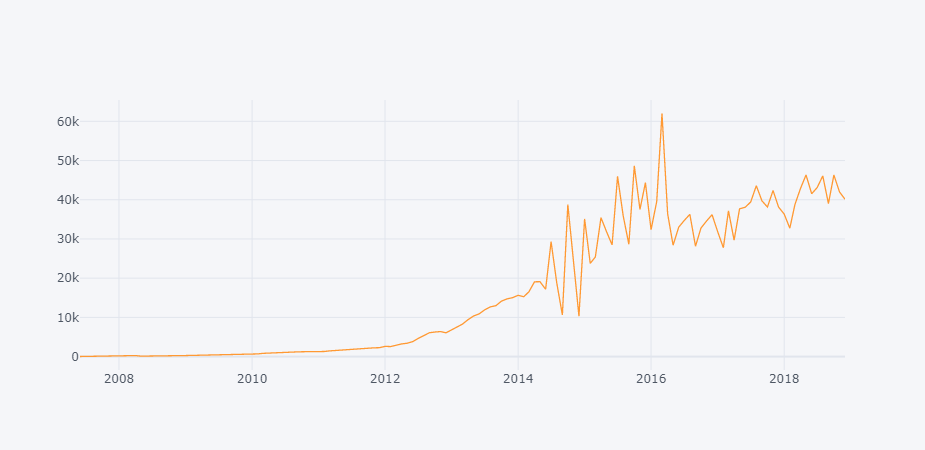

In [14]:
df_loan.groupby("issue_d_date")["term"].count().iplot()

We can clearly see an overall trend of increasing funded loans, as expected when the company increased. We can also split the view by loan_status. 

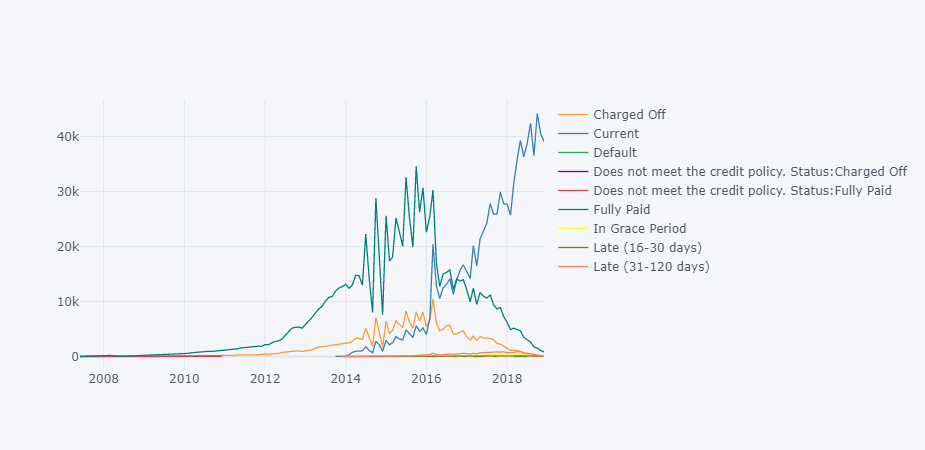

In [15]:
df_loan.groupby(["issue_d_date", "loan_status"])["term"].count().unstack(level="loan_status").iplot()

Of course, we would see a steep increase in current loans lately because they are not paid. The important point on the plot above is to see if there was a time where loans status changed too much form normal behavior. But from 2014 to 2016, all status seems to behave in the same way. 

Also, we note some people can pay the loan before it expires, as indicating by the ones acquired in the end of 2018. Let's try to visualize their differences regarding installment variable.

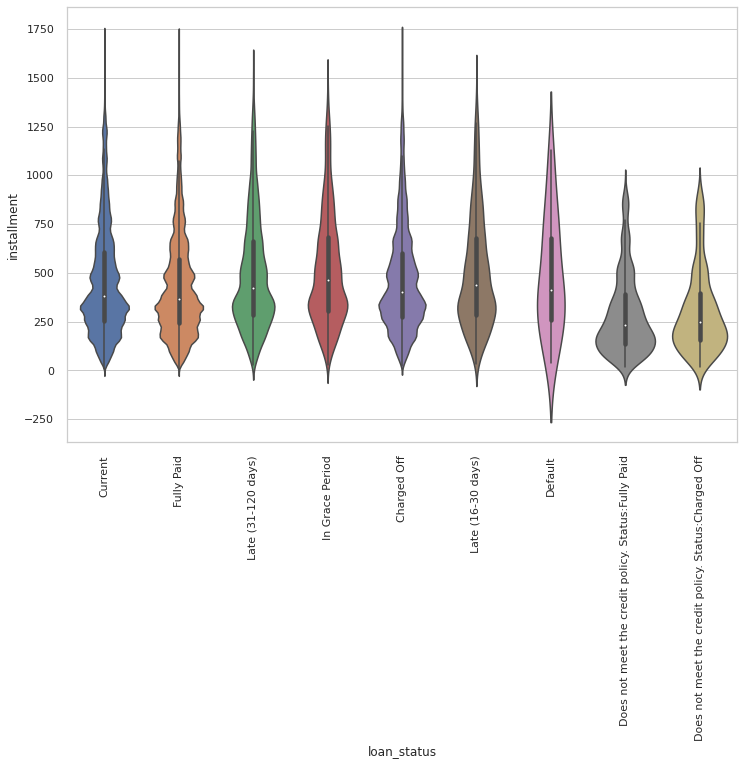

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(x="loan_status", y="installment", data=df_loan, ax=ax)

plt.xticks(rotation=90);

Distributions are close, not a big difference is spotted in this case. Based on term and issue_d_date we can also calculate when the loan expires.

In [7]:
df_loan["term"] = df_loan['term'].str.extract('(\d+)').astype(int)

In [8]:
df_loan["expiration_d_date"] = df_loan.apply(lambda x: x["issue_d_date"] + pd.DateOffset(months=x["term"]), axis=1)

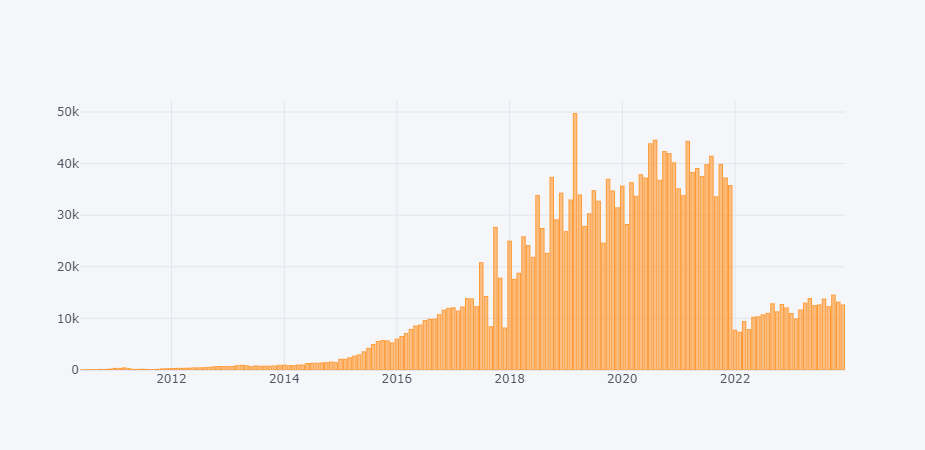

In [19]:
df_loan.groupby(['expiration_d_date'])['term'].count().iplot(kind='bar')

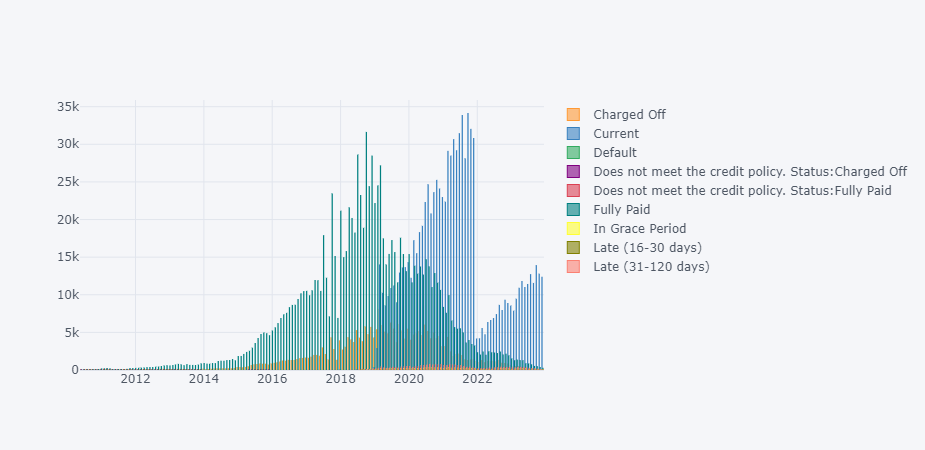

In [20]:
df_loan.groupby(['expiration_d_date', 'loan_status'])['term'].count().unstack(level='loan_status').iplot(kind='bar')

From above plot we can see obvious but still interesting differences in expiration dates distribution for our customers. With that in mind and limited scope, I will filter out rows that indicate *Current*, *Late (16-30 days)*, and *In Grace Period* since they are ongoing loans and we do not have a response variable, also, it is important to mention that we need to use all information at time of application for a specific customer. 

In [9]:
df_loan = df_loan[~(df_loan["loan_status"].isin(["Current", "In Grace Period", "Late (16-30 days)"]))]

In [10]:
df_loan["loan_status_general"] = df_loan["loan_status"].apply(lambda x: "fully_paid" if "Fully Paid" in x else "default")
df_loan["loan_status_general"].value_counts(normalize=True)

fully_paid    0.785931
default       0.214069
Name: loan_status_general, dtype: float64

We have an imbalanced dataset, we will talk more about it later. Let's continuing exploring data. I would like to know next how *dti* and *annual_inc* influence in my loan status variable. Maybe people with more income default less? Debt to Income by definition is extremely important, is that reflected on data?

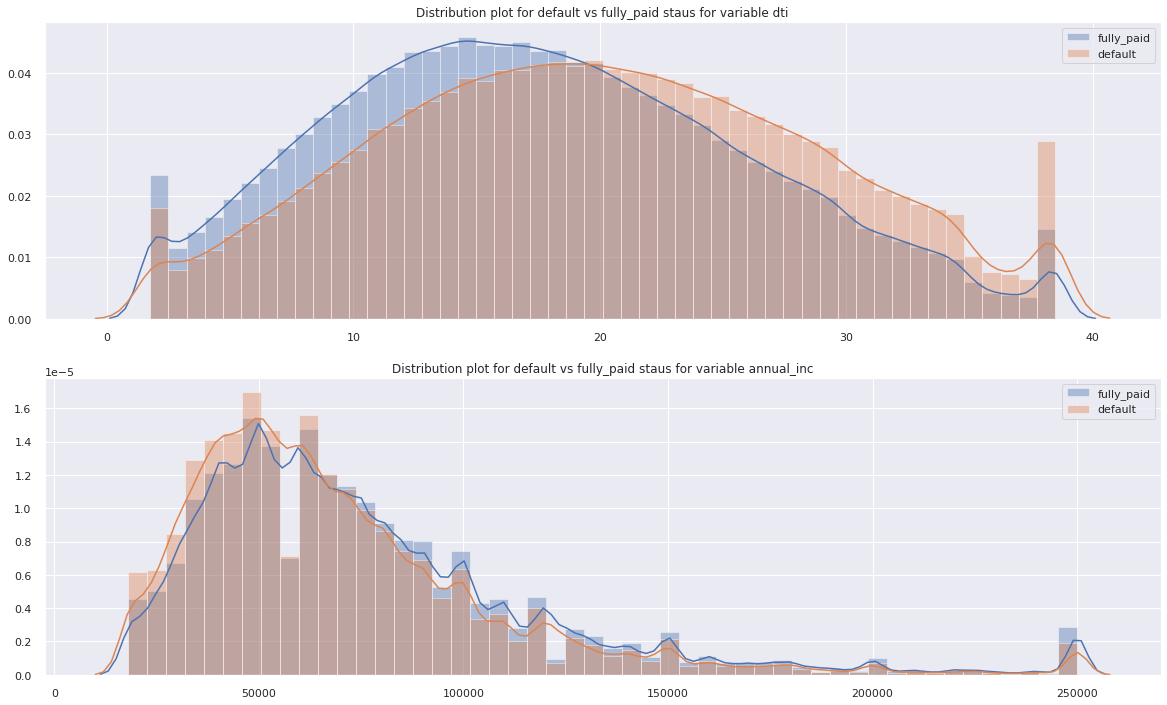

In [118]:
def distplot_loan(df, column, ax):

    lower_, upper_ = np.percentile(df_loan[column].dropna(), [1, 99])

    sns.distplot(df_loan[df_loan["loan_status_general"]=="fully_paid"][column].dropna().clip(lower_, upper_).values, ax=ax, label="fully_paid")
    sns.distplot(df_loan[df_loan["loan_status_general"]=="default"][column].dropna().clip(lower_, upper_).values, ax=ax, label="default")
    
    ax.legend()
    ax.set_title(f"Distribution plot for default vs fully_paid staus for variable {column}")
    
sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

distplot_loan(df_loan, "dti", ax[0])
distplot_loan(df_loan, "annual_inc", ax[1])

We can see a higher likelihood of default for higher debt to income rates. Regarding annual income, this variable alone does not appear to differ both classes. Let's apply same logic with interest rate and installment.

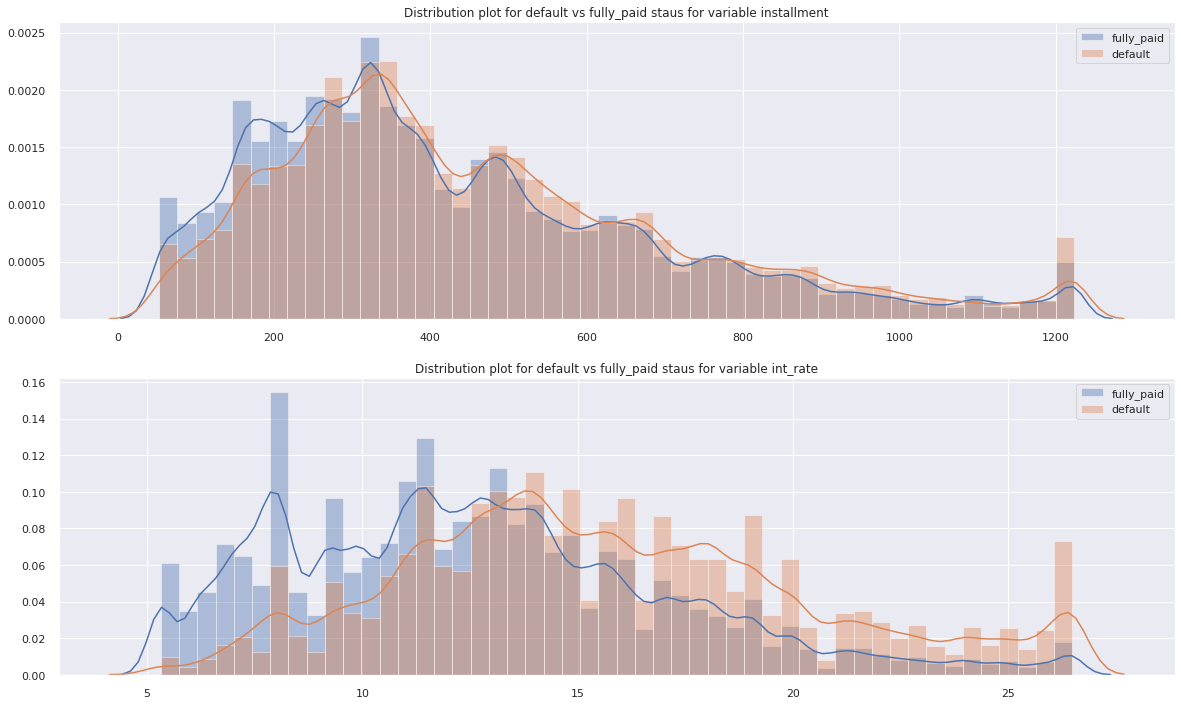

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

distplot_loan(df_loan, "installment", ax[0])
distplot_loan(df_loan, "int_rate", ax[1])

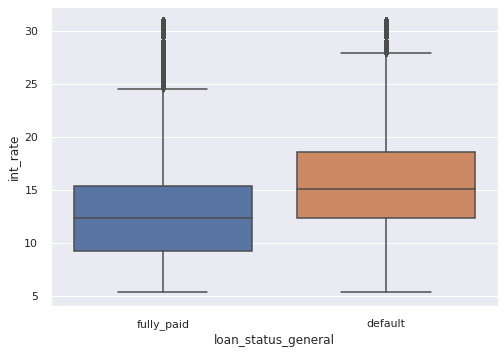

In [54]:
sns.boxplot(x="loan_status_general", y="int_rate", data=df_loan)

Interest rate presents a visual difference in loan status distribution. Of course this can be a confounder variable, because riskier loans could have a higher interest rate, thus having a higher probability of default. Also, it could be that higher interest rates are helping in explaining borrower's default status.

In [11]:
# Capped variables to avoid outliers in visualizations

def capping(df, column):
    lower_, upper_ = np.percentile(df[column].dropna(), [1, 99])
    return df[column].clip(lower_, upper_)
    
df_loan["annual_inc_cap"] = capping(df_loan, "annual_inc")
df_loan["dti_cap"] = capping(df_loan, "dti")

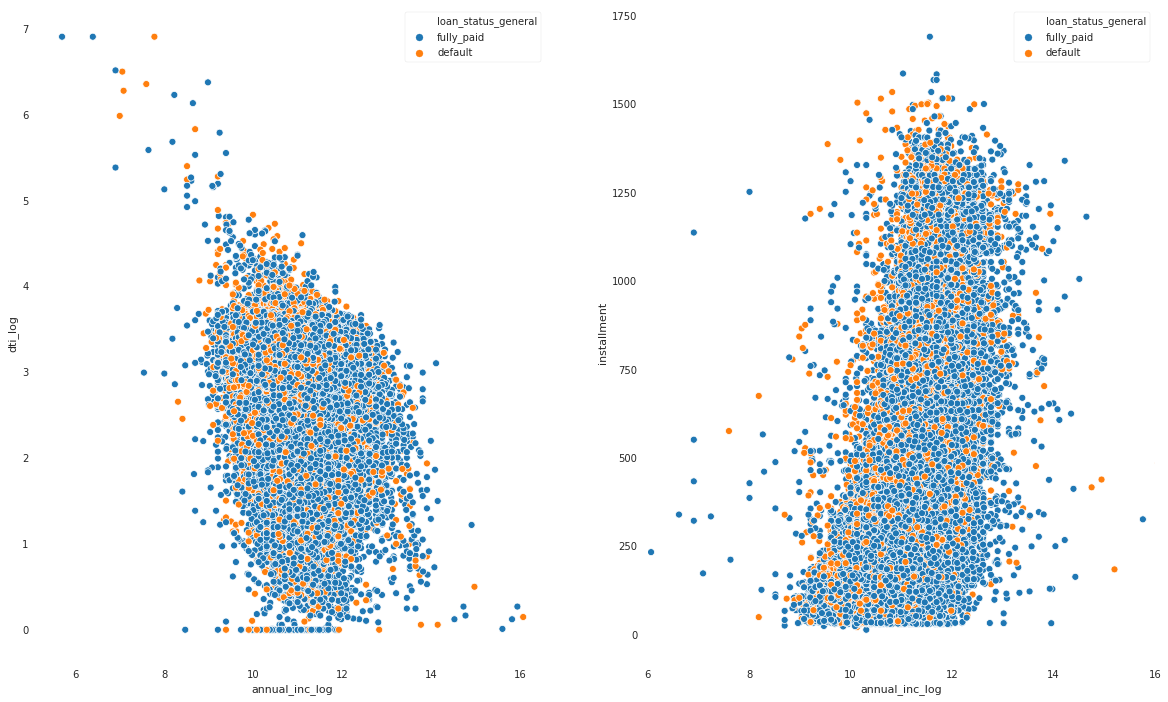

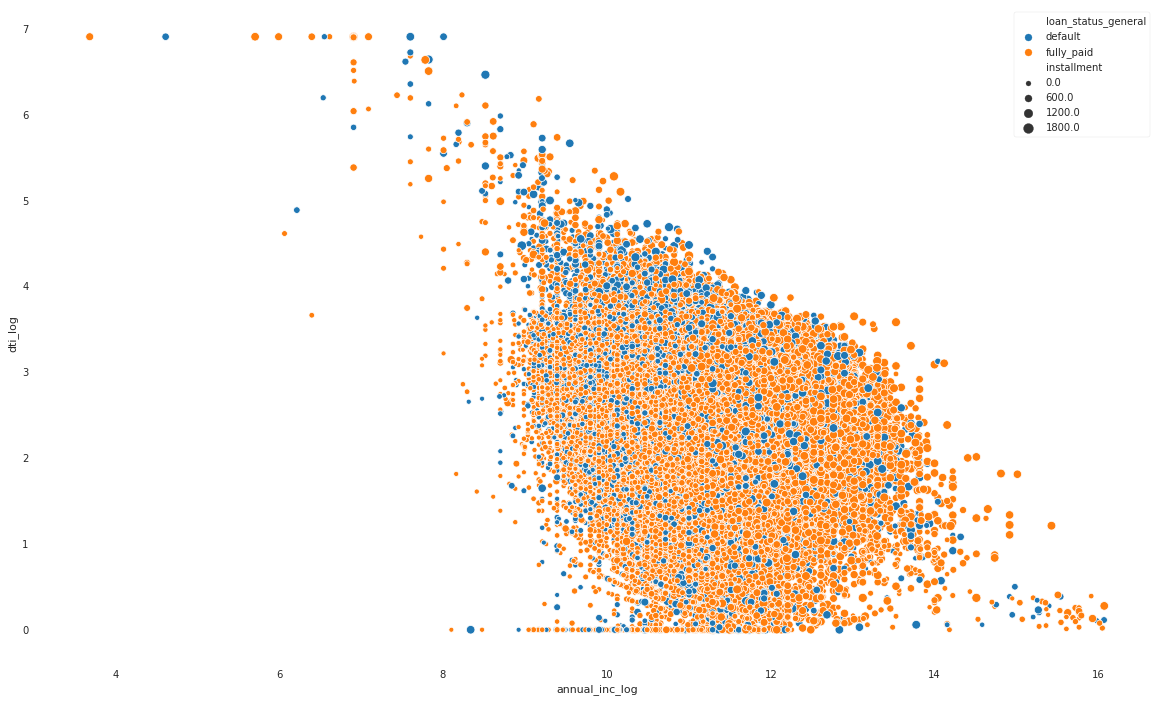

In [19]:
df_loan["annual_inc_log"] = df_loan["annual_inc"].apply(np.log1p)
df_loan["dti_log"] = df_loan["dti"].apply(np.log1p)

fig, ax = plt.subplots(1, 2, figsize=(20, 12))
sns.scatterplot(x="annual_inc_log", y="dti_log", hue="loan_status_general", data=df_loan.sample(frac=.1), ax=ax[0]);
sns.scatterplot(x="annual_inc_log", y="installment", hue="loan_status_general", data=df_loan.sample(frac=.1), ax=ax[1]);

ax[1].set_xlim(6, 16)

fig, ax = plt.subplots(figsize=(20, 12))
sns.scatterplot(x="annual_inc_log", y="dti_log", size="installment", hue="loan_status_general", data=df_loan.sample(frac=0.5), ax=ax);

We can notice a few interest things in the plots above:
 - First, the left plot shows relationship between variable DTI and annual income. We can check a cluster of default applications as dti increases and annual income decreases. This is intuitive insights, since people with less annual income AND higher debt to income rates are prone to default. Both variables are in log scale to supress outliers influence and we can see the big picture.
 - On the right plot, we see annual income (log-scale) and installment scatterplot. We see a slightly positive correlation as self-reported income increases, people get higher installments.

Variable installment does not seem to help at all in identifying default borrowers. We might take into consideration interest rate when treating this variable.

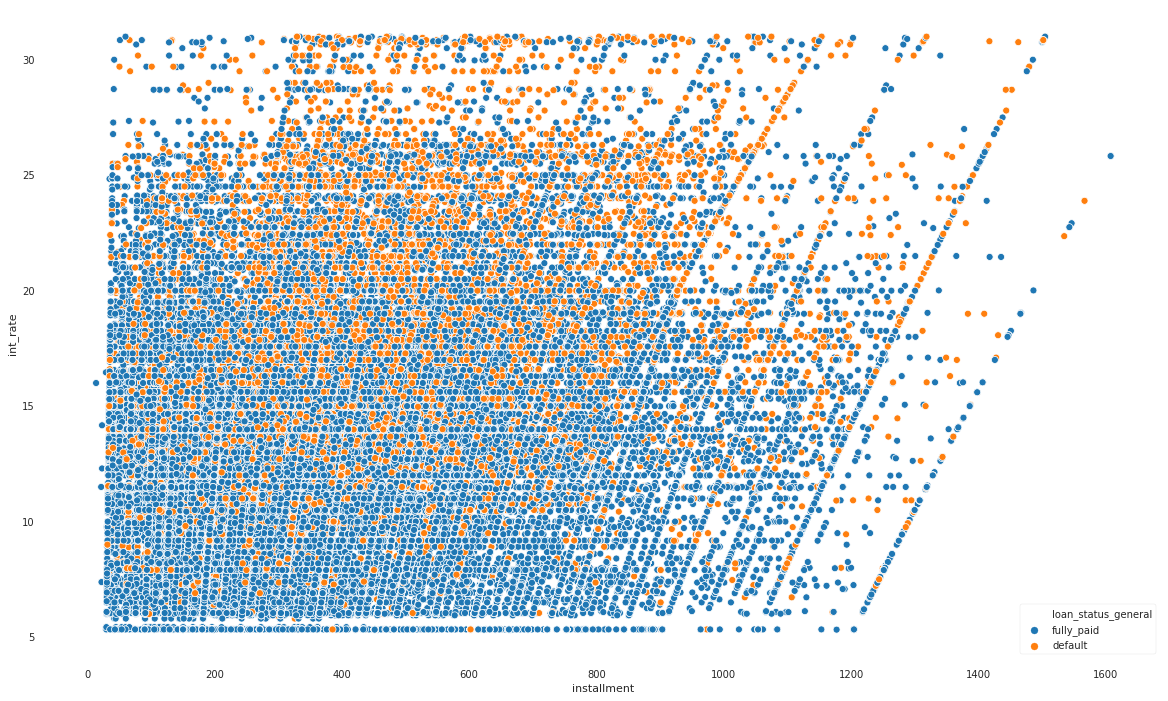

In [13]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.scatterplot(x="installment", y="int_rate", hue="loan_status_general", data=df_loan.sample(frac=.1), ax=ax);

That's interesting! Data is well behaved, likely due to fact that data generation process in this case is determined by zones. I would guess that for some range of values, interest rates increase linearly with installment, showed on the perfect lines crossing the plot. We can also detect on the plot that a simple linear classifier would get a high recall, because the majority of default applicants are on top of specific interest rate.

We do not have total amount for a specific loan, but we can calculate it using as a proxy installment, interest rate and term. I will use a simple compound formula to do that.

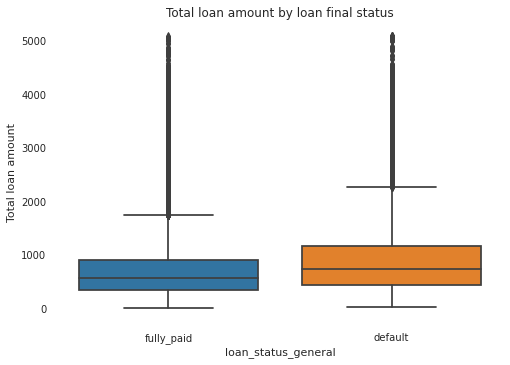

In [112]:
df_loan["total_loan_amount"] = df_loan["installment"]*((1+(df_loan["int_rate"]/100))**(df_loan["term"] / 12))

ax = sns.boxplot(x="loan_status_general", y="total_loan_amount", data=df_loan)
#ax.set_yscale('log')

ax.set_ylabel("Total loan amount")
ax.set_title("Total loan amount by loan final status");

The above plot is on a log scale to help us visualize the overall difference. We can see that this is an important variable as well, and also an intuitive one. I question myself if over time these loans total amount are evenly distributed.

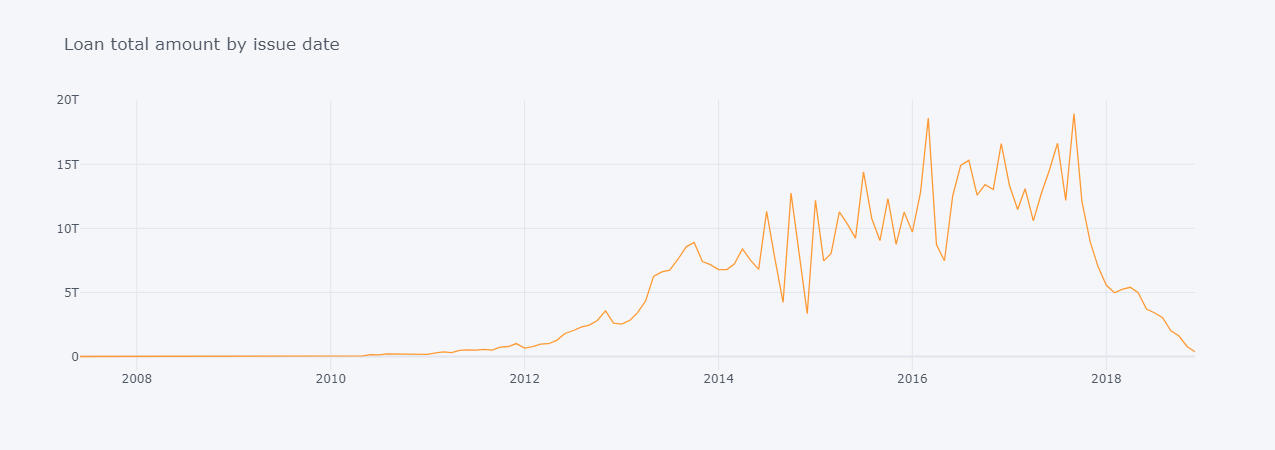

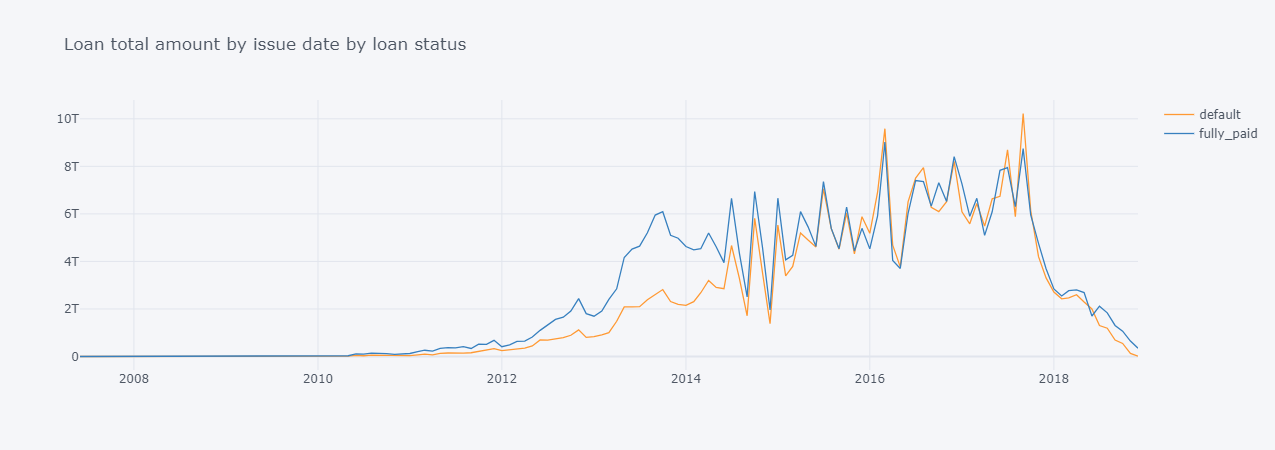

In [15]:
df_loan.groupby(["issue_d_date"])["total_loan_amount"].sum().iplot(title="Loan total amount by issue date")
df_loan.groupby(["issue_d_date", "loan_status_general"])["total_loan_amount"].sum().unstack(level="loan_status_general").iplot(title="Loan total amount by issue date by loan status")

These checks are important to see if our data did not suffer from any structural change, for example, how applications are processed, if company started to take borrowers with higher risk, how economic factors (proxied as time) could impact on defaults, etc. From above, this does not to be a concern, since both data present similar behavior so we are good to go.

We can also check how loan status differ by home_ownership and term.

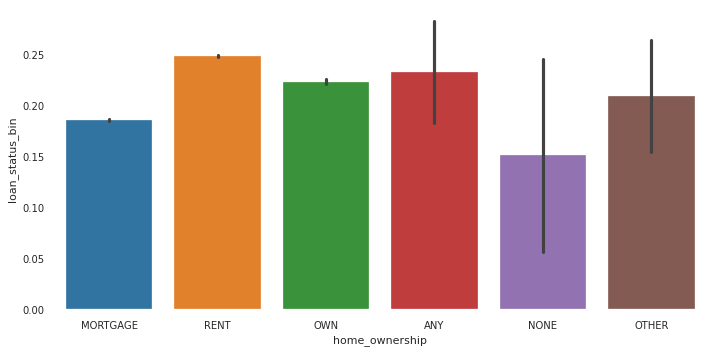

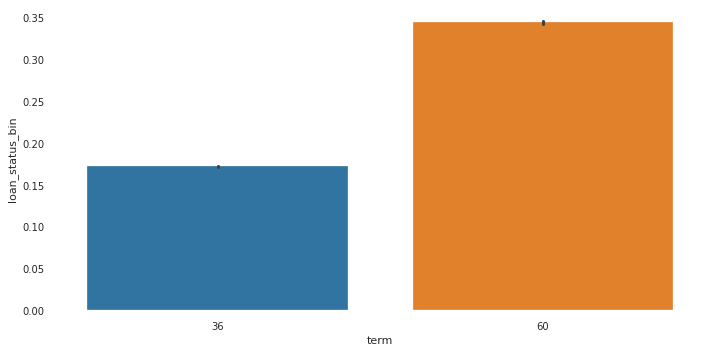

In [21]:
df_loan["loan_status_bin"] = df_loan["loan_status_general"].apply(lambda x: 1 if x=='default' else 0)

sns.catplot(x="home_ownership", y="loan_status_bin", data=df_loan, kind="bar", aspect=2)
sns.catplot(x="term", y="loan_status_bin", data=df_loan, kind="bar", aspect=2)

Higher probabilities of default are associated with home_ownership of Rent, followed by Own and Mortgage. The other ones have higher standard deviation as well, likely due to low count in dataset. Grade and subgrades are determined by LC and I believe are highly associated with default applicants.

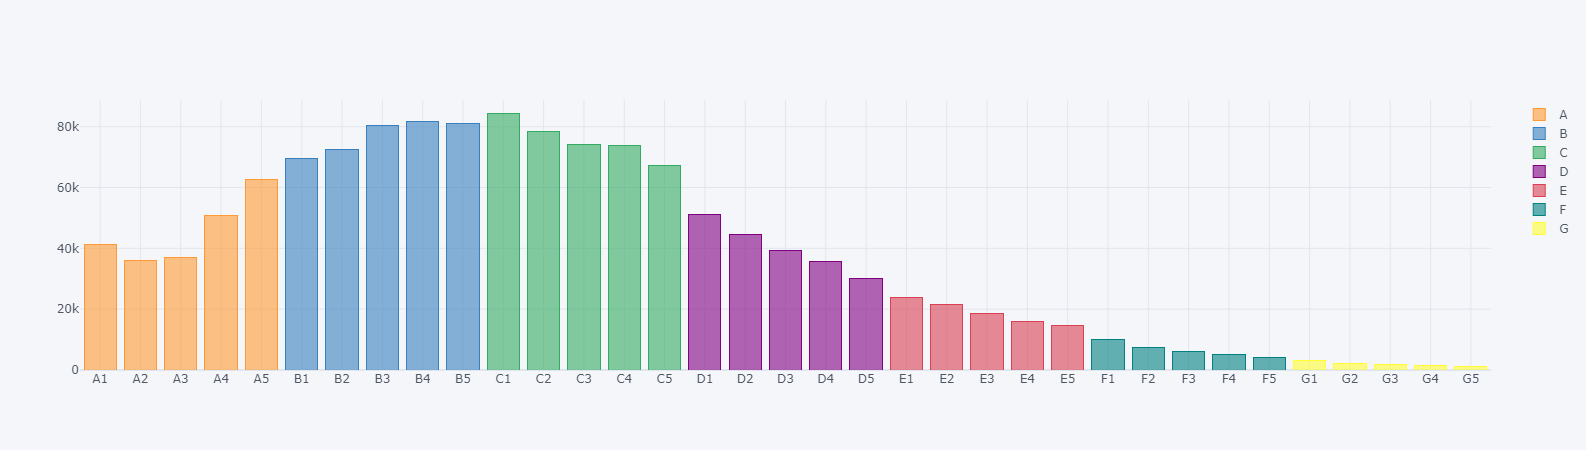

In [39]:
df_loan.groupby(["grade", "sub_grade"])['term'].count().unstack(level="grade").iplot(kind="bar", barmode='stack')

The bar plot above shows distribution of applications by grade and sub_grade. Again, I would expect something similar, with a higher distribution around B and C grades and lower ones as grades diminish. Let's see how they are distributed by loan status.

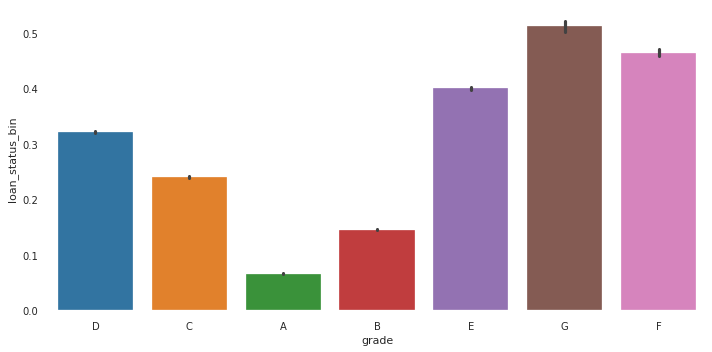

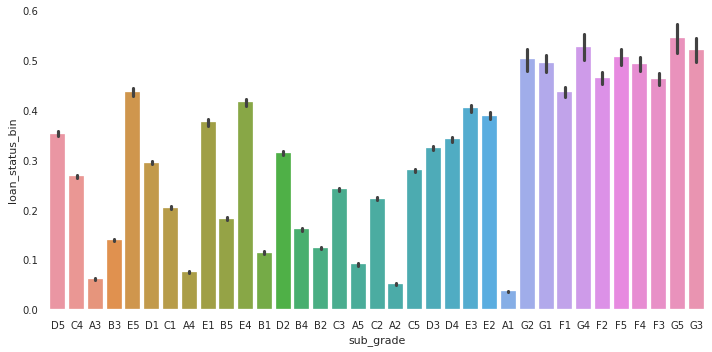

In [40]:
sns.catplot(x="grade", y="loan_status_bin", data=df_loan, kind="bar", aspect=2)
sns.catplot(x="sub_grade", y="loan_status_bin", data=df_loan, kind="bar", aspect=2)

Again, we can see that for lower grades and sub-grades, we have higher probability of default. Moreover, this variable reflects how risk a loan is, and it influences installment and interest rates.
Another interest variable is earliest_cr_line, maybe people at more time in the market are more responsible in paying back their debts.

In [53]:
# It will be a flotat
df_loan["credit_time_in_years"] = np.round((df_loan['issue_d_date'] - pd.to_datetime(df_loan["earliest_cr_line"])) / np.timedelta64(1, 'Y'), 2)

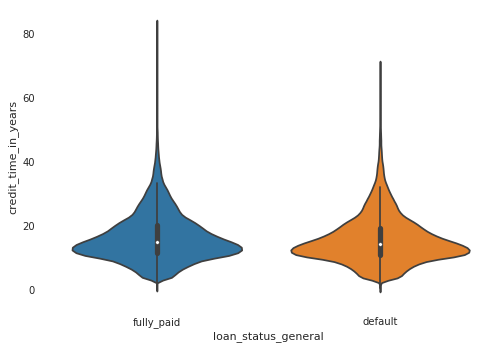

In [61]:
sns.violinplot(x="loan_status_general", y="credit_time_in_years", data=df_loan)

In [57]:
df_loan[df_loan["credit_time_in_years"] > 80]

term  int_rate  installment grade sub_grade home_ownership  \
1543216    36     13.59        169.9     C        C2           RENT   

         annual_inc   issue_d loan_status   dti earliest_cr_line  recoveries  \
1543216     24000.0  Jul-2017  Fully Paid  25.5         Apr-1934         0.0   

        last_pymnt_d application_type issue_d_date expiration_d_date  \
1543216     Aug-2018       Individual   2017-07-01        2020-07-01   

        loan_status_general  annual_inc_cap  dti_cap  annual_inc_log  \
1543216          fully_paid         24000.0     25.5       10.085851   

          dti_log  total_loan_amount  loan_status_bin  credit_time_in_years  
1543216  3.277145      527666.173872                0                 83.25

We can see a few weird outliers for earliest_cr_line. The case above would indicate a person of 103 years, reasoning that it took his first credit line at age 18. It is probably a mistake. Since it is self-reported variable, again is a good peice of advice to use column capping to limit variables. It does not seem to be a good variable to indicate if a person will default or not alone. 

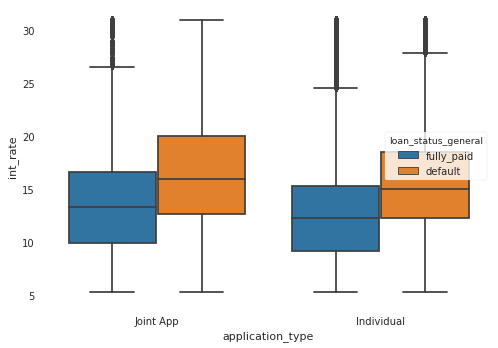

In [69]:
sns.boxplot(x="application_type", y="int_rate", hue="loan_status_general", data=df_loan)

Let's explore other relationships in our dataset.

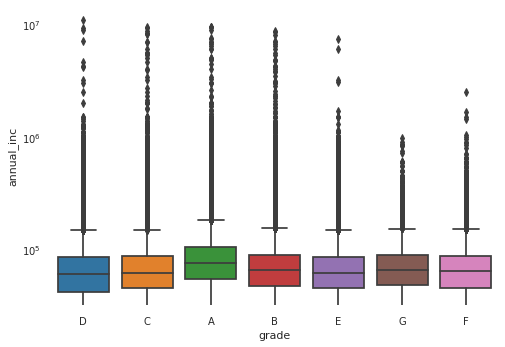

In [95]:
ax = sns.boxplot(x="grade", y="annual_inc", data=df_loan)
ax.set_yscale("log")

Although last_payment_date is not a variable available to our case (predicting default on origination), we can use it to understand WHEN borrowers will default, in the first month, second, third? Maybe, MAYBE, this can help us understand better our dataset. I will consider that null last payment is equal to issue date.

In [149]:
df_loan["last_pymnt_d"] = df_loan["last_pymnt_d"].fillna(value=df["issue_d_date"])
df_loan["time_to_last_payment_in_months"] = ((pd.to_datetime(df_loan["last_pymnt_d"]) - df_loan["issue_d_date"]) / np.timedelta64(1, "M")).round()

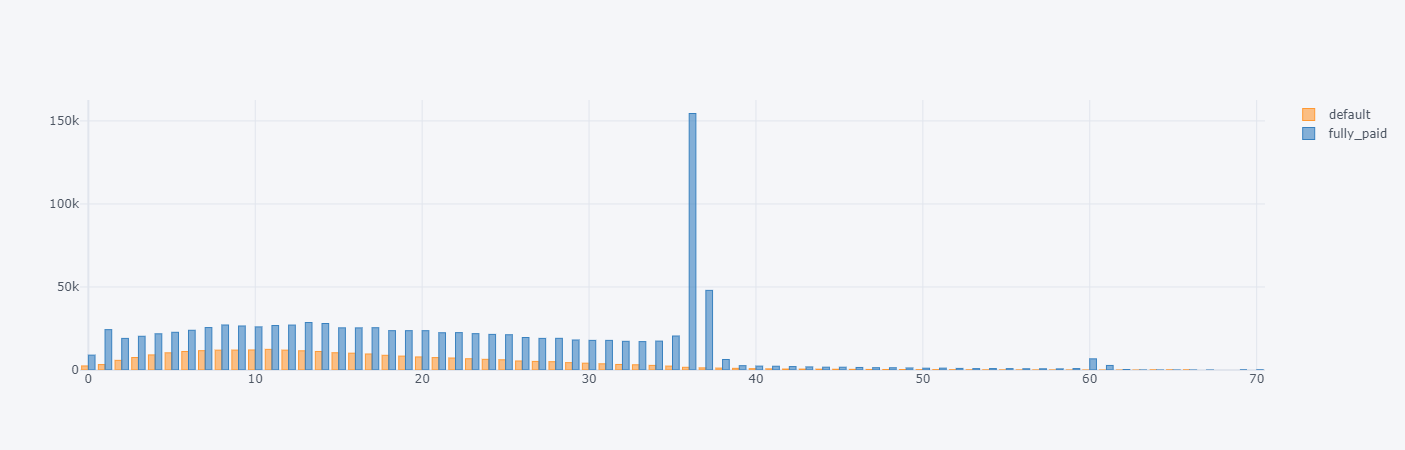

In [155]:
df_loan.groupby(["time_to_last_payment_in_months", "loan_status_general"]).size().unstack(level="loan_status_general").iplot(kind="bar")

Of course, a person can be late on payment and do it 

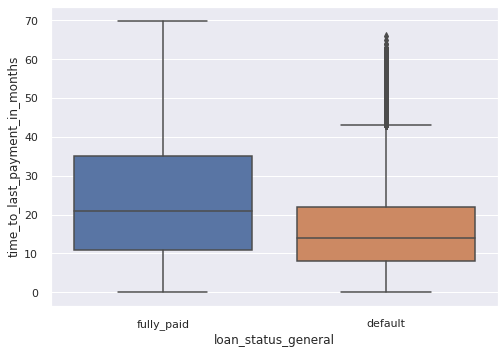

In [146]:
sns.boxplot(x="loan_status_general", y="time_to_last_payment_in_months", data=df_loan)

## Feature Engineering

We have created already some features in our data. But let's dedicate a section to devise interactions between variables that can help our models. It is well-known that ratio variable can help tree based models, so let's start by that. We have already debt to income ratio, but we can think an installment to income ratio, that is, how much it will weight on borrowers' finance the proposed installment? In the most simplistic form, we can multiply that by 12 and divide by reported income.

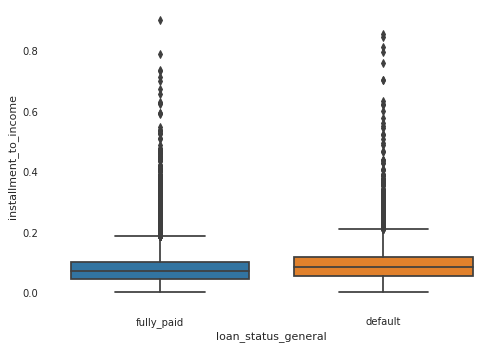

In [103]:
# using cap column
df_loan["installment_to_income"] = (df_loan["installment"]*12) / (df_loan["annual_inc_cap"]+1)

ax = sns.boxplot(x="loan_status_general", y="installment_to_income", data=df_loan[df_loan["annual_inc"]!=0].sample(frac=0.1))

**NOTE:** I am aware of data leakage in this scenario, because I am using information from data that would ideally be in my test set. Here is the feature engineering notebook with visualization aid, I will build more appropriate pipelines using sklearn to avoid leakage.

We can apply same logic to calculate loan to income ratio based on total term.

In [117]:
df_loan["total_loan_to_income"] = (df_loan["total_loan_amount"] / (df_loan["annual_inc_cap"]*(df_loan["term"] / 12)))*100
df_loan.head(5)

term  int_rate  installment grade sub_grade home_ownership  annual_inc  \
100    36     22.35      1151.16     D        D5       MORTGAGE    100000.0   
152    60     16.14       975.71     C        C4       MORTGAGE     45000.0   
170    36      7.56       622.68     A        A3       MORTGAGE    100000.0   
186    36     11.31       147.99     B        B3           RENT     38500.0   
215    36     27.27       345.18     E        E5       MORTGAGE    450000.0   

      issue_d loan_status    dti earliest_cr_line  recoveries last_pymnt_d  \
100  Dec-2018  Fully Paid  30.46         Jan-2012         0.0     Jan-2019   
152  Dec-2018  Fully Paid  50.53         Jun-2009         0.0     Feb-2019   
170  Dec-2018  Fully Paid  18.92         Feb-1999         0.0     Feb-2019   
186  Dec-2018  Fully Paid   4.64         Dec-2003         0.0     Feb-2019   
215  Dec-2018  Fully Paid  12.37         Oct-1997         0.0     Feb-2019   

    application_type issue_d_date expiration_d_date loan_status_general  \
100        Joint App   2018-12-01        2021-12-01          fully_paid   
152        Joint App   2018-12-01        2023-12-01          fully_paid   
170        Joint App   2018-12-01        2021-12-01          fully_paid   
186       Individual   2018-12-01        2021-12-01          fully_paid   
215        Joint App   2018-12-01        2021-12-01          fully_paid   

     annual_inc_cap  dti_cap  annual_inc_log   dti_log  total_loan_amount  \
100        100000.0    30.46       11.512935  3.448717        2108.373804   
152         45000.0    38.46       10.714440  3.942164        2061.720858   
170        100000.0    18.92       11.512935  2.991724         774.849393   
186         38500.0     4.64       10.558439  1.729884         204.096200   
215        250000.0    12.37       13.017005  2.593013         711.580039   

     loan_status_bin  credit_time_in_years  installment_to_income  \
100                0                  6.92               0.138138   
152                0                  9.50               0.260184   
170                0                 19.83               0.074721   
186                0                 15.00               0.046126   
215                0                 21.17               0.016569   

     total_loan_to_income  
100              0.702791  
152              0.916320  
170              0.258283  
186              0.176707  
215              0.094877

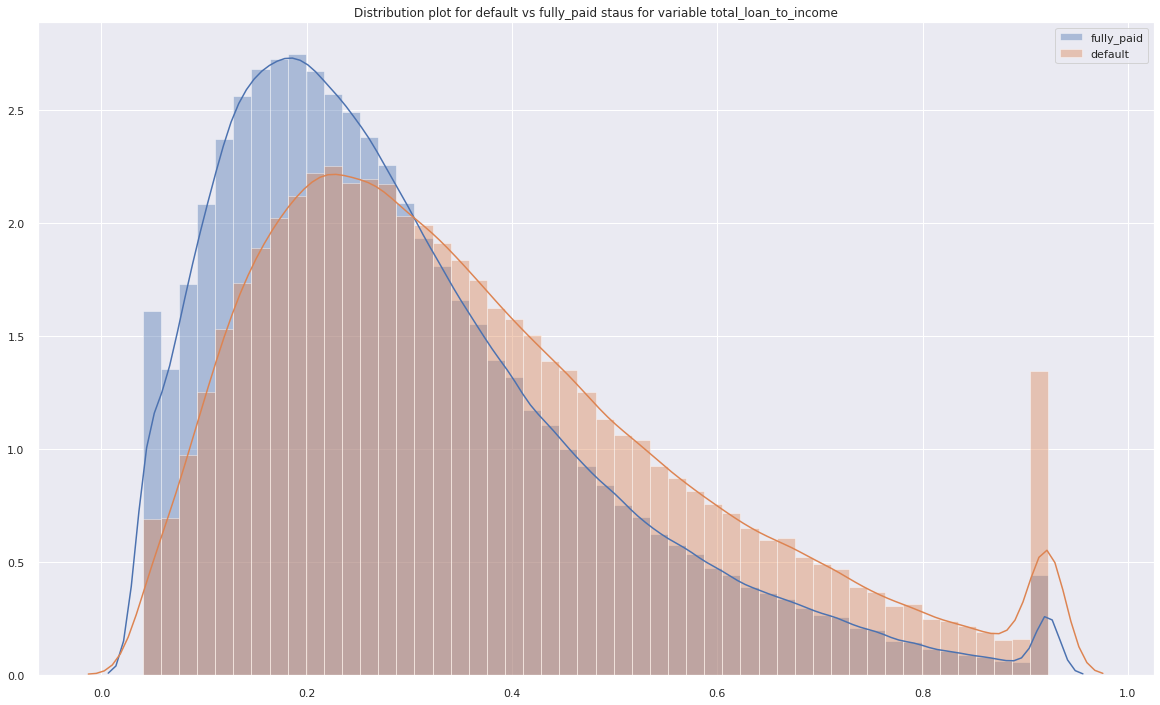

In [120]:
fig, ax = plt.subplots(figsize=(20, 12))
distplot_loan(df_loan, "total_loan_to_income", ax=ax)

We can see a shift for default variable. Keep in mind that this is an extremely difficult task, and any signal can help a model to define better which features will be included in final one.

In [158]:
df_loan.shape

(1328284, 27)